In [1]:
from __future__ import print_function

import os
import sys
import torch
import io
import time
import numpy as np
from PIL import Image
import torch.onnx
from datetime import datetime
from torch.autograd import Variable
from miscc.config import cfg
from miscc.utils import build_super_images2
from model import RNN_ENCODER, G_NET

In [2]:
import cPickle as pickle

In [3]:
import os
import time
import random

In [4]:
from matplotlib.pyplot import imshow
%matplotlib inline

In [5]:
def vectorize_caption(wordtoix, caption, copies=2):
    # create caption vector
    tokens = caption.split(' ')
    cap_v = []
    for t in tokens:
        t = t.strip().encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0 and t in wordtoix:
            cap_v.append(wordtoix[t])

    # expected state for single generation
    captions = np.zeros((copies, len(cap_v)))
    for i in range(copies):
        captions[i,:] = np.array(cap_v)
    cap_lens = np.zeros(copies) + len(cap_v)

    #print(captions.astype(int), cap_lens.astype(int))
    #captions, cap_lens = np.array([cap_v, cap_v]), np.array([len(cap_v), len(cap_v)])
    #print(captions, cap_lens)
    #return captions, cap_lens

    return captions.astype(int), cap_lens.astype(int)


In [6]:
x = pickle.load(open('data/captions.pickle', 'rb'))
ixtoword = x[2]
wordtoix = x[3]
del x

### Load models

In [7]:
word_len = len(wordtoix)

text_encoder = RNN_ENCODER(word_len, nhidden=cfg.TEXT.EMBEDDING_DIM)
state_dict = torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
text_encoder.load_state_dict(state_dict)
text_encoder.eval()
        
netG = G_NET()
state_dict = torch.load(cfg.TRAIN.NET_G, map_location=lambda storage, loc: storage)
netG.load_state_dict(state_dict)
netG.eval()


G_NET(
  (ca_net): CA_NET(
    (fc): Linear(in_features=256, out_features=400, bias=True)
    (relu): GLU(
    )
  )
  (h_net1): INIT_STAGE_G(
    (fc): Sequential(
      (0): Linear(in_features=200, out_features=16384, bias=False)
      (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True)
      (2): GLU(
      )
    )
    (upsample1): Sequential(
      (0): Upsample(scale_factor=2, mode=nearest)
      (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (3): GLU(
      )
    )
    (upsample2): Sequential(
      (0): Upsample(scale_factor=2, mode=nearest)
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (3): GLU(
      )
    )
    (upsample3): Sequential(
      (0): Upsample(scale_factor=2, mode=nearest)
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 

In [8]:
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
def generate(caption, copies=2):
    # load word vector
    captions, cap_lens  = vectorize_caption(wordtoix, caption, copies)
    n_words = len(wordtoix)

    # only one to generate
    batch_size = captions.shape[0]

    nz = cfg.GAN.Z_DIM
    captions = Variable(torch.from_numpy(captions), volatile=True)
    cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)
    noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
    

    #######################################################
    # (1) Extract text embeddings
    #######################################################
    hidden = text_encoder.init_hidden(batch_size)
    words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
    mask = (captions == 0)
        

    #######################################################
    # (2) Generate fake images
    #######################################################
    noise.data.normal_(0, 1)
    fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask)

    # G attention
    cap_lens_np = cap_lens.cpu().data.numpy()

    # storing to blob storage
    container_name = "images"
    full_path = "https://attgan.blob.core.windows.net/images/%s"
    prefix = datetime.now().strftime('%Y/%B/%d/%H_%M_%S_%f')
    imgs = []
    # only look at first one
    #j = 0
    for j in range(batch_size):
        for k in range(len(fake_imgs)):
            im = fake_imgs[k][j].data.cpu().numpy()
            im = (im + 1.0) * 127.5
            im = im.astype(np.uint8)
            im = np.transpose(im, (1, 2, 0))
#             im = Image.fromarray(im)
            imgs.append(im)
    imshow(imgs[-1])


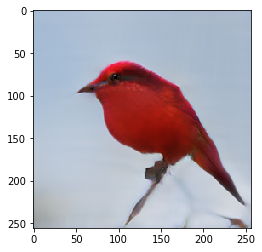

In [45]:
generate("a red bird")

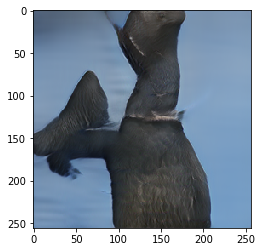

In [40]:
generate("a big bird")

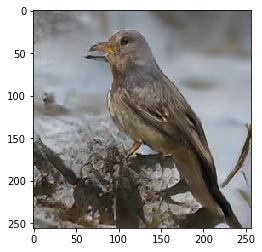

In [13]:
generate("a bird eating a grain")

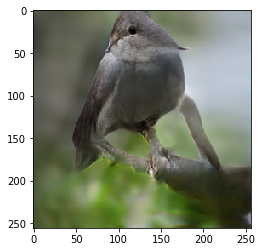

In [14]:
generate("birds fighting")

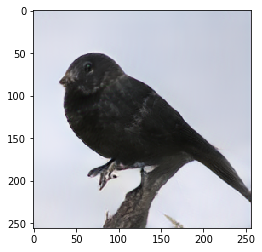

In [64]:
generate("small black bird sitting on a tree")

GlobalAttention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)


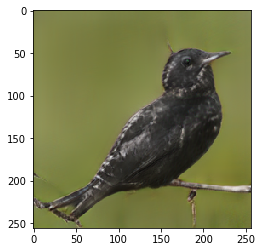

In [10]:
generate("small black bird sitting on a tree")